# Task 1 : Set up colab gpu runtime environment

In [2]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.24
    Uninstalling albucore-0.0.24:
      Successfully uninstalled albucore-0.0.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.8 requires albucore==0.0.24, but you have albucore 0.0.28 which is incompatible.


# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

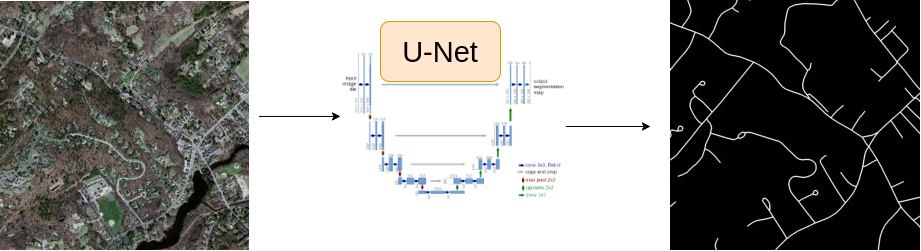

# Download Subset Dataset

In [3]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

Cloning into 'Road_seg_dataset'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411 (from 1)
Receiving objects: 100% (411/411), 851.74 MiB | 16.59 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (401/401), done.


# Some Common Imports

In [4]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [5]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [6]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'
DEVICE = 'cuda'
EPOCHS = 25
BATCH_SIZE = 2
LR = 0.003
IMG_SIZE = 512


ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [8]:
idx = 2
row = df.iloc[idx]

image_path = DATA_DIR + row.images
mask_path = DATA_DIR+ row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0



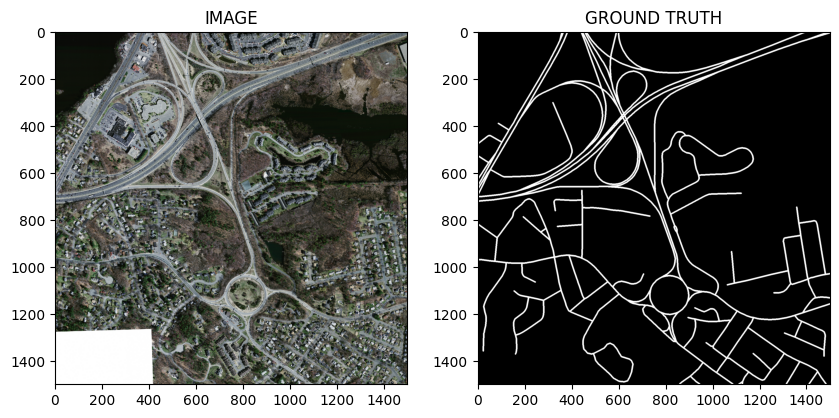

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [10]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
# albumentation
import albumentations as A

In [12]:
def get_train_augs():
  train_transform = A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])
def get_valid_augs():
  valid_transform = A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [13]:
from torch.utils.data import Dataset

In [14]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR+ row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/255.0
    mask = torch.round(torch.Tensor(mask)/255.0)

    return image, mask

In [15]:
train_set = SegmentationDataset(train_df, get_train_augs())
valid_set = SegmentationDataset(valid_df, get_valid_augs())

In [16]:
print(f"Number of training samples : {len(train_set)}")
print(f"Number of validation samples : {len(valid_set)}")

Number of training samples : 159
Number of validation samples : 40


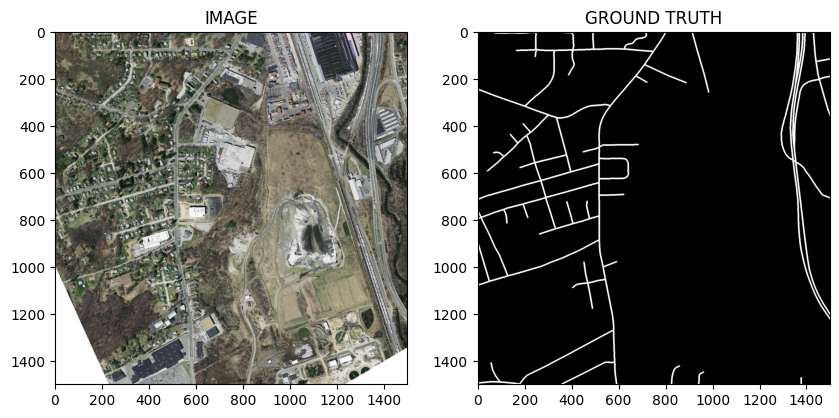

In [17]:
idx = 5
image, mask = train_set[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(valid_set, batch_size=BATCH_SIZE)

In [20]:
print(f"Total number of batches in train loader : {len(trainloader)}")
print(f"Total number of batches in validation loader : {len(validloader)}")

Total number of batches in train loader : 80
Total number of batches in validation loader : 20


In [21]:
for images, masks in trainloader:
  print(f"One batch images shape : {images.shape}")
  print(f"One batch masks shape : {masks.shape}")
  break;


One batch images shape : torch.Size([2, 3, 1500, 1500])
One batch masks shape : torch.Size([2, 1, 1500, 1500])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torch import nn

In [23]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()
    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None

    )
  def forward(self, images, masks = None):
    logits = self.backbone(images)
    if masks != None:
      return logits, DiceLoss(mode='binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)
    return logits

In [24]:
model = SegmentationModel()

model.to(DEVICE)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

SegmentationModel(
  (backbone): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): S

# Task 7 : Create Train and Validation Function

In [25]:
def train(model, trainloader, optimizer):
  model.train()
  total_loss = 0

  for images, masks in tqdm(trainloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)


    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(trainloader)

In [26]:
def eval_fn(model, validloader, device):
  model.eval()
  total_loss = 0

  with torch.no_grad():
    for images, masks in tqdm(validloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)
      total_loss += loss.item()

  return total_loss/len(validloader)

# Task 8 : Train Model

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [28]:
best_loss = np. inf
for i in range (EPOCHS) :
  train_loss = train(model, trainloader, optimizer)
  valid_loss = eval_fn(model, validloader, DEVICE)
  if valid_loss < best_loss:
      torch.save(model.state_dict(), "best-model.pt")
      print ("SAVED-MODEL" )
      best_loss = valid_loss
  print(f"Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}")

100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


SAVED-MODEL
Epoch : 1 Train Loss : 0.7486232213675976 Valid Loss : 0.6446153163909912


100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


Epoch : 2 Train Loss : 0.562621508538723 Valid Loss : 0.6644453644752503


100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


SAVED-MODEL
Epoch : 3 Train Loss : 0.5344790454953909 Valid Loss : 0.5961670711636543


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


SAVED-MODEL
Epoch : 4 Train Loss : 0.5184570692479611 Valid Loss : 0.5805133953690529


100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


SAVED-MODEL
Epoch : 5 Train Loss : 0.49856765270233155 Valid Loss : 0.5440108463168144


100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Epoch : 6 Train Loss : 0.4800973556935787 Valid Loss : 0.5562451109290123


100%|██████████| 20/20 [00:09<00:00,  2.02it/s]


SAVED-MODEL
Epoch : 7 Train Loss : 0.4715631095692515 Valid Loss : 0.5322964549064636


100%|██████████| 20/20 [00:09<00:00,  2.00it/s]


Epoch : 8 Train Loss : 0.4600920617580414 Valid Loss : 0.5571094080805779


100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


Epoch : 9 Train Loss : 0.4540196042507887 Valid Loss : 0.5466064155101776


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


SAVED-MODEL
Epoch : 10 Train Loss : 0.4560466712340713 Valid Loss : 0.5296702414751053


100%|██████████| 20/20 [00:09<00:00,  2.02it/s]


Epoch : 11 Train Loss : 0.4614080602303147 Valid Loss : 0.5411618605256081


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


SAVED-MODEL
Epoch : 12 Train Loss : 0.4439418280497193 Valid Loss : 0.5212354086339474


100%|██████████| 20/20 [00:09<00:00,  2.02it/s]


Epoch : 13 Train Loss : 0.4441871913149953 Valid Loss : 0.5265917986631393


100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


Epoch : 14 Train Loss : 0.4477175364270806 Valid Loss : 0.5215762034058571


100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


Epoch : 15 Train Loss : 0.4297967465594411 Valid Loss : 0.5217834025621414


100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


SAVED-MODEL
Epoch : 16 Train Loss : 0.41640154030174015 Valid Loss : 0.5122458346188068


100%|██████████| 20/20 [00:10<00:00,  2.00it/s]


SAVED-MODEL
Epoch : 17 Train Loss : 0.4204697947949171 Valid Loss : 0.5086121164262295


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


Epoch : 18 Train Loss : 0.4155090421438217 Valid Loss : 0.5296105399727822


100%|██████████| 20/20 [00:09<00:00,  2.07it/s]


Epoch : 19 Train Loss : 0.42409469205886124 Valid Loss : 0.534496384114027


100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Epoch : 20 Train Loss : 0.439490001834929 Valid Loss : 0.5740465223789215


100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Epoch : 21 Train Loss : 0.43254299405962227 Valid Loss : 0.5567054629325867


100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Epoch : 22 Train Loss : 0.4065569218248129 Valid Loss : 0.5151702970266342


100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


SAVED-MODEL
Epoch : 23 Train Loss : 0.40678909942507746 Valid Loss : 0.5083246611058712


100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


Epoch : 24 Train Loss : 0.39533927012234926 Valid Loss : 0.5092015400528908


100%|██████████| 20/20 [00:09<00:00,  2.06it/s]

Epoch : 25 Train Loss : 0.38904609587043526 Valid Loss : 0.5236671820282937


# Task 9 : Inference

In [30]:
idx = 17
model.load_state_dict(torch.load("best-model.pt"))
image, masks = valid_set[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0))
print(logits_mask)

tensor([[[[-3.1528, -4.4640, -4.5247,  ..., -4.4824, -4.4909, -3.0365],
          [-4.2399, -6.3897, -6.4949,  ..., -6.4929, -6.5787, -4.4490],
          [-4.2645, -6.4338, -6.5342,  ..., -6.6636, -6.7612, -4.5961],
          ...,
          [-3.8845, -5.8597, -5.7646,  ..., -6.5410, -6.2124, -4.1404],
          [-4.0433, -6.0501, -5.9301,  ..., -6.3761, -6.1761, -4.1929],
          [-3.0463, -4.3458, -4.2446,  ..., -4.4266, -4.4664, -3.0540]]]],
       device='cuda:0', grad_fn=<ConvolutionBackward0>)


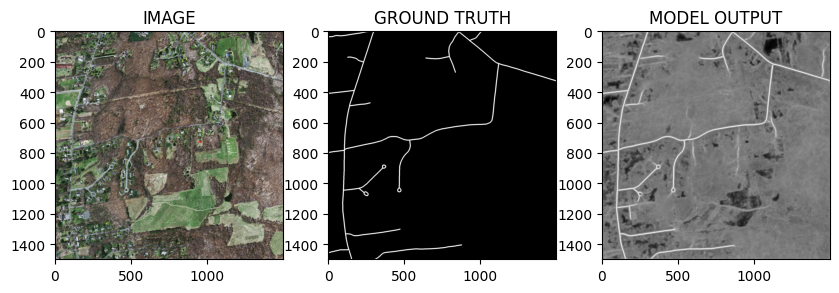

In [34]:
helper.show_image(image, masks, logits_mask.squeeze(0).detach().cpu())

In [40]:
model = SegmentationModel()
model.load_state_dict(torch.load("best-model.pt"))
model.to(DEVICE)
print("Model loaded and moved to device.")

Model loaded and moved to device.


In [41]:
def iou_score(logits, masks):
    # Apply sigmoid to logits to get probabilities
    pred_masks = torch.sigmoid(logits)
    # Convert probabilities to binary masks
    pred_masks = (pred_masks > 0.5).float()
    # Flatten tensors for easier calculation
    pred_masks = pred_masks.view(-1)
    masks = masks.view(-1)

    # Calculate intersection and union
    intersection = (pred_masks * masks).sum()
    union = pred_masks.sum() + masks.sum() - intersection

    # Calculate IoU
    iou = (intersection + 1e-7) / (union + 1e-7)  # Add a small epsilon to avoid division by zero
    return iou

In [42]:
def evaluate_model(model, dataloader, device):
    model.eval()
    total_iou = 0.0
    with torch.no_grad():
        for images, masks in tqdm(dataloader):
            images = images.to(device)
            masks = masks.to(device)

            logits = model(images)
            total_iou += iou_score(logits, masks)

    return total_iou / len(dataloader)

average_iou = evaluate_model(model, validloader, DEVICE)

100%|██████████| 20/20 [00:05<00:00,  3.51it/s]


In [44]:
print(f"Average IoU on the validation set: {average_iou:.4f}")

Average IoU on the validation set: 0.4950
